In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas

data = pandas.read_csv("/content/drive/Othercomputers/내 노트북/File/spamVenv/files/spam.csv", encoding="UTF-8").dropna(axis=0)


originData = data[["Subject", "Spam/Ham"]].rename(columns={"Spam/Ham":"isSpam", "Subject":"content"}).drop_duplicates() #제목, 스팸여부 & 중복제거(결측치)
originData["isSpam"] = originData['isSpam'].replace(["ham", "spam"], [0, 1]) #범주형 -> 수치형


# # data["isSpam"].value_counts() #스팸 비율
# # print(f'스팸 : 정상 비율 : {data["isSpam"].value_counts()[0]/data["isSpam"].size} : {data["isSpam"].value_counts()[1]/data["isSpam"].size}')

_index = originData['content'].apply(lambda x: isinstance(x, (int, float))).index[originData['content'].apply(lambda x: isinstance(x, (int, float)))]
originData = originData.drop(_index)
originData['content'].apply(lambda x: isinstance(x, (int, float))).sum()

originData = originData.reset_index()[["content", "isSpam"]]
originData


,content,isSpam
0,"vastar resources , inc .",0
1,calpine daily gas nomination,0
2,re : issue,0
3,meter 7268 nov allocation,0
4,mcmullen gas for 11 / 99,0
...,...,...
24007,= ? iso - 8859 - 2 ? q ? my _ proposition ? =,1
24008,make big bucks in the medical field bait - exc...,1
24009,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,1
24010,all prescript medicines are on special . to be...,1


In [30]:
from sklearn.model_selection import train_test_split

Xdata = originData["content"]
Ydata = originData["isSpam"]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.2, random_state=123, stratify=Ydata)

print(f'훈련데이터 정상 메일 = {round(Ytrain.value_counts()[0]/len(Ytrain) * 100, 3)}%')
print(f'훈련데이터 스팸 메일 = {round(Ytrain.value_counts()[1]/len(Ytrain) * 100, 3)}%')
print(f'총 훈련데이터 수 : {Ydata.size}개 중 {Ytrain.size}개, {round(Ytrain.size/Ydata.size*100, 3)}%')
print(f'테스트데이터 정상 메일 = {round(Ytest.value_counts()[0]/len(Ytest) * 100, 3)}%')
print(f'테스트데이터 스팸 메일 = {round(Ytest.value_counts()[1]/len(Ytest) * 100, 3)}%')
print(f'총 테스트데이터 수 : {Ydata.size}개 중 {Ytest.size}개, {round(Ytest.size/Ydata.size*100, 3)}%')




훈련데이터 정상 메일 = 53.001%
훈련데이터 스팸 메일 = 46.999%
총 훈련데이터 수 : 24012개 중 19209개, 79.998%
테스트데이터 정상 메일 = 53.009%
테스트데이터 스팸 메일 = 46.991%
총 테스트데이터 수 : 24012개 중 4803개, 20.002%


In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from numpy import mean
import itertools

tokenizer = Tokenizer() #토큰화 진행
tokenizer.fit_on_texts(Xdata) #각 단어를 숫자와 매핑시키는 집합 생성

meanLen = round(mean([len(i) for i in Xdata])) #문장의 길이를 통일하기 위해 문장의 길이 평균값

encodedXtrain = tokenizer.texts_to_sequences(Xtrain) #각 문장의 단어들을 위 집합을 기반으로 [abc, cba] -> [3,39] 와 같이 변경 : encoding된 느낌
finalXtrain = pad_sequences(encodedXtrain, maxlen=meanLen, padding='post') #입력 데이터 최종본 : 위에서 숫자로 이루어진 문장을 모두 같은 길이의 문장으로 만들어줌(0으로 채워넣는 pad sequence)

encodedXtest = tokenizer.texts_to_sequences(Xtest)
finalXtest = pad_sequences(encodedXtest, maxlen=meanLen, padding='post')


print(Xtrain.iloc[0])
print()
print(text_to_word_sequence(Xtrain.iloc[0]))
print()
print(dict(itertools.islice(tokenizer.word_index.items(), 8)))
print()
print(encodedXtrain[0])
print()
print(finalXtrain[0])

fw :

['fw']

{'re': 1, 'for': 2, 'the': 3, 'to': 4, 'you': 5, 'your': 6, 'and': 7, 'fw': 8}

[8]

[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LayerNormalization
from tensorflow.keras.utils import plot_model

models = []
for i in range(1, 31):
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1, 32)) #Embedding(단어 집합 길이 + 1, 출력 차원, 입력 최대 길이) -> 입력층
    model.add(SimpleRNN(32))
    model.add(LayerNormalization())
    model.add(Dense(1, activation="sigmoid")) #sigmoid함수를 활성화 함수로 하는 Dense, 출력 1개 -> 출력층
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    models.append({"model":model, "epoch":i})




In [33]:

for model in models:
    model["model"].fit(finalXtrain, Ytrain, epochs=model["epoch"], batch_size=100) # 전체 데이터를 2번, 32개씩 풀고 채점


193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6915 - loss: 0.5518
Epoch 1/2
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6682 - loss: 0.5826
Epoch 2/2
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9366 - loss: 0.1665
Epoch 1/3
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7161 - loss: 0.5327
Epoch 2/3
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9558 - loss: 0.1238
Epoch 3/3
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9773 - loss: 0.0649
Epoch 1/4
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6130 - loss: 0.6289
Epoch 2/4
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9364 - loss: 0.1771
Epoch 3/4
193/193 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9808 - loss: 0.0595
Epoch 4/4
193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9895 - loss: 0.0344
Epoch 1/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5571 - loss: 0.6931
Epoch 2/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9020 - loss: 0.2448
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8772 - loss: 0.2952
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9024 - loss: 0.2391
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8885 - loss: 0.3086
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7631 - loss: 0.6715
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8764 - loss: 0.3926
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9013 - loss: 0.3644
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9013 - loss: 0.3664
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8913 - loss: 0.3733
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8946 - loss: 0.3720
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8795 - loss: 0.5126
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8868 - loss: 0.4200
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8807 - loss: 0.4005
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 

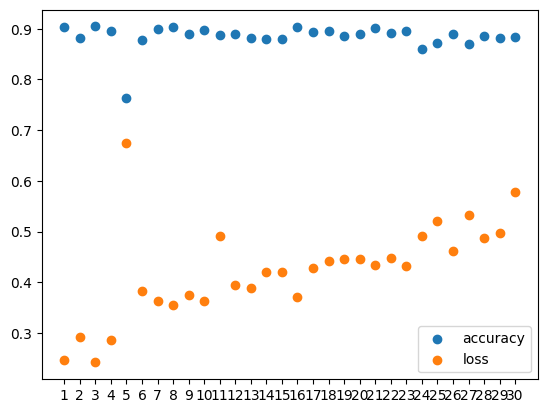

In [34]:
import matplotlib.pyplot as plt
results = []

for model in models:
    loss, accuracy = model['model'].evaluate(finalXtest, Ytest, batch_size = 100)
    results.append({"accuracy" : accuracy, "loss" : loss})

y1 = [i["accuracy"] for i in results]
y2 = [i["loss"] for i in results]

plt.scatter([model["epoch"] for model in models], y1, label="accuracy")
plt.scatter([model["epoch"] for model in models], y2, label="loss")
plt.xticks([model["epoch"] for model in models])

plt.legend()
plt.show()